# Federated Keras MNIST Tutorial

In [1]:
#Install Tensorflow and MNIST dataset if not installed
!pip install tensorflow==2.3.1 ~/repos/openfl-fork

#Alternatively you could use the intel-tensorflow build
# !pip install intel-tensorflow==2.3.0

Processing /home/itrushkin/repos/openfl-fork


  Created wheel for openfl: filename=openfl-1.0.1-py3-none-any.whl size=3329869 sha256=e25958fe34deb27f437f5eac7130a327999e822c1ed99e4815e8b544bf5e081e
  Stored in directory: /home/itrushkin/.cache/pip/wheels/ed/ad/82/f26baafab4be32d052fb76a6f56c9a76ce6903cc3eed7bb394
Successfully built openfl
  Attempting uninstall: openfl
    Found existing installation: openfl 1.0.1
    Uninstalling openfl-1.0.1:
      Successfully uninstalled openfl-1.0.1


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import openfl.native as fx
from openfl.federated import FederatedModel,FederatedDataSet

In [3]:
def test_intel_tensorflow():
    """
    Check if Intel version of TensorFlow is installed
    """
    import tensorflow as tf

    print("We are using Tensorflow version {}".format(tf.__version__))

    major_version = int(tf.__version__.split(".")[0])
    if major_version >= 2:
        from tensorflow.python import _pywrap_util_port
        print("Intel-optimizations (DNNL) enabled:",
              _pywrap_util_port.IsMklEnabled())
    else:
        print("Intel-optimizations (DNNL) enabled:")

test_intel_tensorflow()

We are using Tensorflow version 2.3.1
Intel-optimizations (DNNL) enabled: False


After importing the required packages, the next step is setting up our openfl workspace. To do this, simply run the `fx.init()` command as follows:

In [4]:
#Setup default workspace, logging, etc.
fx.init('keras_cnn_mnist')

Creating Workspace Directories
Creating Workspace Templates

New workspace directory structure:
workspace
├── plan
│   ├── defaults
│   │   ├── data_loader.yaml
│   │   ├── network.yaml
│   │   ├── tasks_keras.yaml
│   │   ├── collaborator.yaml
│   │   ├── assigner.yaml
│   │   ├── task_runner.yaml
│   │   ├── defaults
│   │   ├── tasks_tensorflow.yaml
│   │   ├── aggregator.yaml
│   │   ├── tasks_torch.yaml
│   │   └── tasks_fast_estimator.yaml
│   ├── plan.yaml
│   ├── data.yaml
│   └── cols.yaml
├── logs
├── final_pytorch_model.h5
├── agg_to_col_two_signed_cert.zip
├── data
│   └── MNIST
│       ├── raw
│       └── processed
├── cert
│   ├── ca
│   │   ├── signing-ca.crt
│   │   ├── root-ca.crt
│   │   ├── signing-ca
│   │   ├── signing-ca.csr
│   │   └── root-ca
│   ├── server
│   │   ├── agg_nnlicv611.inn.intel.com.csr
│   │   ├── agg_nnlicv611.csr
│   │   ├── agg_none.key
│   │   ├── agg_nnlicv611.crt
│   │   ├── agg_none.crt
│   │   ├── agg_nnlicv611.inn.intel.com.key
│   │   ├─

Now we are ready to define our dataset and model to perform federated learning on. The dataset should be composed of a numpy arrayWe start with a simple fully connected model that is trained on the MNIST dataset. 

In [5]:
#Import and process training, validation, and test images/labels

# Set the ratio of validation imgs, can't be 0.0
VALID_PERCENT = 0.3

(X_train, y_train), (X_test, y_test) = mnist.load_data()
split_on = int((1 - VALID_PERCENT) * len(X_train))

train_images = X_train[0:split_on,:,:]
train_labels = to_categorical(y_train)[0:split_on,:]

valid_images = X_train[split_on:,:,:]
valid_labels = to_categorical(y_train)[split_on:,:]

test_images = X_test
test_labels = to_categorical(y_test)

def preprocess(images):
    #Normalize
    images = (images / 255) - 0.5
    #Flatten
    images = images.reshape((-1, 784))
    return images

# Preprocess the images.
train_images = preprocess(train_images)
valid_images = preprocess(valid_images)
test_images = preprocess(test_images)

feature_shape = train_images.shape[1]
classes = 10

class UnbalancedFederatedDataset(FederatedDataSet):
    def split(self, num_collaborators, shuffle=True, equally=False):
        train_idx = self.split_dirichlet(self.y_train, num_collaborators)
        X_train = np.array([self.X_train[idx] for idx in train_idx])
        y_train = np.array([self.y_train[idx] for idx in train_idx])
        
        valid_idx = self.split_dirichlet(self.y_valid, num_collaborators)
        X_valid = np.array([self.X_valid[idx] for idx in valid_idx])
        y_valid = np.array([self.y_valid[idx] for idx in valid_idx])
        
        return [
            FederatedDataSet(
                X_train[i],
                y_train[i],
                X_valid[i],
                y_valid[i],
                batch_size=self.batch_size,
                num_classes=self.num_classes
            ) for i in range(num_collaborators)
        ]
    
    def split_dirichlet(self, labels, num_collaborators):
        min_size = 0
        alpha = 0.5
        n = len(labels)
        while min_size < 10:
            idx_batch = [[] for _ in range(num_collaborators)]
            # for each class in the dataset
            for k in range(self.num_classes):
                idx_k = np.where(np.argmax(labels, axis=1) == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(alpha, num_collaborators))
                ## Balance
                proportions = np.array([p * (len(idx_j) < n / num_collaborators) for p, idx_j in zip(proportions, idx_batch)])
                proportions = proportions / proportions.sum()
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k,proportions))]
                min_size = min([len(idx_j) for idx_j in idx_batch])
        return idx_batch

fl_data = UnbalancedFederatedDataset(train_images,train_labels,valid_images,valid_labels,batch_size=32,num_classes=classes)

In [6]:
def train_iteration(self, batch_generator, mu=0, metrics=[], **kwargs):
        global_weights = [w + 0 for w in self.model.weights]
        for X, y in batch_generator:
            X, y = tf.convert_to_tensor(X), tf.convert_to_tensor(y)
            with tf.GradientTape() as tape:
                logits = self.model(X, training=True)  # Logits for this minibatch
                loss_value = self.model.compiled_loss(y, logits, regularization_losses=self.model.losses)
                grads = tape.gradient(loss_value, self.model.trainable_weights)
                grads = [
                    g + mu * (w - w0) for g, w, w0 in zip(
                    grads, self.model.weights, global_weights)
                ]
                self.model.optimizer.apply_gradients(zip(grads, self.model.weights))
        
        results = []
        for metric in metrics:
            value = np.mean([self.model.history.history[metric]])
            results.append(Metric(name=metric, value=np.array(value)))
        return results
    
def bind(fn, instance):
    setattr(instance, fn.__name__, fn.__get__(instance, instance.__class__))

class FedProxModel(FederatedModel):
    def __init__(self, **kwargs):
        def build_model(feature_shape, classes):
            model = Sequential([
                Dense(64, input_shape=feature_shape, activation='relu'),
                Dense(64, activation='relu'),
                Dense(classes, activation='softmax')
            ])

            model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)
            return model
        super().__init__(build_model, **kwargs)
        bind(train_iteration, self.runner)

    def setup(self, num_collaborators, **kwargs):
        return [
            FedProxModel(data_loader=data_slice, **kwargs)
            for data_slice in self.data_loader.split(
                num_collaborators, equally=True
            )]

In [7]:
#Create a federated model using the build model function and dataset
fl_model = FedProxModel(data_loader=fl_data)

The `FederatedModel` object is a wrapper around your Keras, Tensorflow or PyTorch model that makes it compatible with openfl. It provides built in federated training and validation functions that we will see used below. Using it's `setup` function, collaborator models and datasets can be automatically defined for the experiment. 

In [8]:
collaborator_models = fl_model.setup(num_collaborators=10)
collaborators = {f'col{col}':collaborator_models[col] for col in range(len(collaborator_models))}#, 'three':collaborator_models[2]}

In [9]:
#Original MNIST dataset
print(f'Original training data size: {len(train_images)}')
print(f'Original validation data size: {len(valid_images)}\n')

#Collaborator one's data
print(f'Collaborator one\'s training data size: {len(collaborator_models[0].data_loader.X_train)}')
print(f'Collaborator one\'s validation data size: {len(collaborator_models[0].data_loader.X_valid)}\n')

#Collaborator two's data
print(f'Collaborator two\'s training data size: {len(collaborator_models[1].data_loader.X_train)}')
print(f'Collaborator two\'s validation data size: {len(collaborator_models[1].data_loader.X_valid)}\n')

#Collaborator three's data
#print(f'Collaborator three\'s training data size: {len(collaborator_models[2].data_loader.X_train)}')
#print(f'Collaborator three\'s validation data size: {len(collaborator_models[2].data_loader.X_valid)}')

Original training data size: 42000
Original validation data size: 18000

Collaborator one's training data size: 2402
Collaborator one's validation data size: 1409

Collaborator two's training data size: 3405
Collaborator two's validation data size: 2046



We can see the current plan values by running the `fx.get_plan()` function

In [10]:
#Get the current values of the plan. Each of these can be overridden
import json
print(json.dumps(fx.get_plan(), indent=4, sort_keys=True))

{
    "aggregator.settings.best_state_path": "save/keras_cnn_mnist_best.pbuf",
    "aggregator.settings.db_store_rounds": 1,
    "aggregator.settings.init_state_path": "save/keras_cnn_mnist_init.pbuf",
    "aggregator.settings.last_state_path": "save/keras_cnn_mnist_last.pbuf",
    "aggregator.settings.rounds_to_train": 10,
    "aggregator.template": "openfl.component.Aggregator",
    "assigner.settings.task_groups": [
        {
            "name": "train_and_validate",
            "percentage": 1.0,
            "tasks": [
                "aggregated_model_validation",
                "train",
                "locally_tuned_model_validation"
            ]
        }
    ],
    "assigner.template": "openfl.component.RandomGroupedAssigner",
    "collaborator.settings.db_store_rounds": 1,
    "collaborator.settings.delta_updates": false,
    "collaborator.settings.opt_treatment": "RESET",
    "collaborator.template": "openfl.component.Collaborator",
    "data_loader.settings.batch_size": 2

Now we are ready to run our experiment. If we want to pass in custom plan settings, we can easily do that with the `override_config` parameter

In [11]:
#Run experiment, return trained FederatedModel
final_fl_model = fx.run_experiment(collaborators,override_config={'aggregator.settings.rounds_to_train':5})

In [12]:
#Save final model and load into keras
final_fl_model.save_native('final_model')
model = tf.keras.models.load_model('./final_model')

In [13]:
#Test the final model on our test set
model.evaluate(test_images,test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.4803 - accuracy: 0.8290


[0.48033782839775085, 0.8289999961853027]

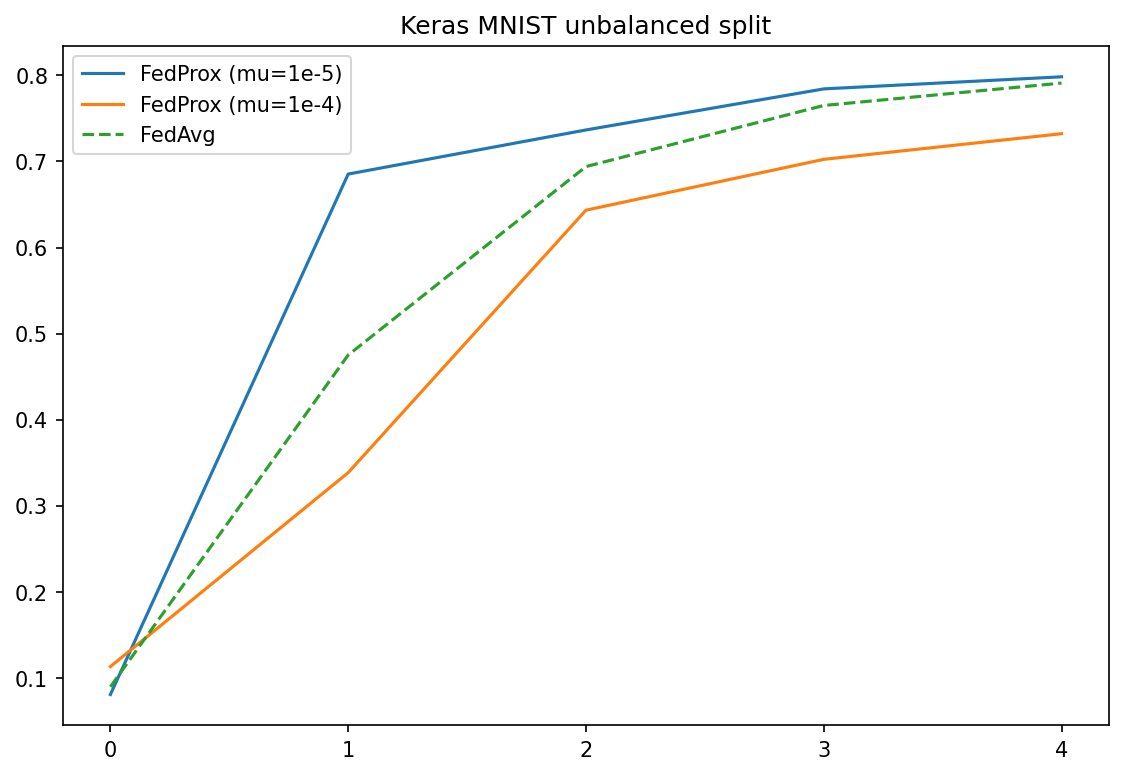

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fedprox_keras_mnist_5=[
    0.0636507123708725,
0.053402237594127655,
0.11835245043039322,
0.020270269364118576,
0.09914203733205795,
0.05958549305796623,
0.273017555475235,
0.06408839672803879,
0.052706554532051086,
0.004825737327337265,
0.2403997927904129,
0.44272178411483765,
0.7398331761360168,
0.674924910068512,
0.8765490651130676,
0.8792746067047119,
0.7328366041183472,
0.809944748878479,
0.7008547186851501,
0.7565683722496033,
0.2540768086910248,
0.45133504271507263,
0.921793520450592,
0.7364864945411682,
0.9027645587921143,
0.8948186635971069,
0.7557211518287659,
0.8756905794143677,
0.7393162250518799,
0.8343163728713989,
0.33666491508483887,
0.5736433863639832,
0.9040667414665222,
0.7845345139503479,
0.9337463974952698,
0.9046632051467896,
0.8536455631256104,
0.9127072095870972,
0.7649572491645813,
0.8745308518409729,
0.3671751618385315,
0.6020671725273132,
0.9228363037109375,
0.7942942976951599,
0.938989520072937,
0.9160621762275696,
0.8451303839683533,
0.9220994710922241,
0.7763532996177673,
0.8986595273017883,
]
fedprox_keras_mnist_4 = [0.16068866848945618,
0.14973261952400208,
0.07121662050485611,
0.018136020749807358,
0.1413911134004593,
0.041611332446336746,
0.2365945428609848,
0.1066666692495346,
0.09049999713897705,
0.116683728992939,
0.09899569302797318,
0.4817695617675781,
0.35608309507369995,
0.06498740613460541,
0.40136829018592834,
0.5652943849563599,
0.5545625686645508,
0.4300000071525574,
0.24150000512599945,
0.19140225648880005,
0.35939741134643555,
0.6922702789306641,
0.5385756492614746,
0.5511335134506226,
0.5792474150657654,
0.9641434550285339,
0.7892756462097168,
0.7409523725509644,
0.5920000076293945,
0.6274309158325195,
0.4340028762817383,
0.7433155179023743,
0.6194362044334412,
0.6584382653236389,
0.6419612169265747,
0.9632580876350403,
0.8598306775093079,
0.7933333516120911,
0.6614999771118164,
0.6499488353729248,
0.46341463923454285,
0.7530384063720703,
0.68916916847229,
0.7309823632240295,
0.688141405582428,
0.9698981642723083,
0.8706490993499756,
0.8147618770599365,
0.6825000047683716,
0.6601842641830444,]
fedprox_keras_mnist_0 = [0.0276792049407959,
0.40518084168434143,
0.0,
0.0,
0.020477816462516785,
0.0717703327536583,
0.023569023236632347,
0.2981942296028137,
0.03193376585841179,
0.02050326205790043,
0.7870830297470093,
0.5620723366737366,
0.8848921060562134,
0.581818163394928,
0.17519909143447876,
0.38915470242500305,
0.3468013405799866,
0.37579306960105896,
0.3790656328201294,
0.2702702581882477,
0.8715400695800781,
0.796187698841095,
0.921416699886322,
0.8035353422164917,
0.4971558451652527,
0.4645135700702667,
0.5279461145401001,
0.7984382510185242,
0.49911296367645264,
0.7609506249427795,
0.8956707119941711,
0.8582600355148315,
0.9346984028816223,
0.8671717047691345,
0.6245733499526978,
0.5203348994255066,
0.6612794399261475,
0.833089292049408,
0.6339443922042847,
0.821528434753418,
0.903477668762207,
0.8563050031661987,
0.9286109805107117,
0.9126262664794922,
0.660978376865387,
0.5618022084236145,
0.6936026811599731,
0.8501707911491394,
0.6564162969589233,
0.8867660760879517,]

plt.figure(figsize=(9,6), dpi=150)
plt.title('Keras MNIST unbalanced split')
plt.plot([np.mean(round_acc) for round_acc in np.array_split(fedprox_keras_mnist_5, 5)], label='FedProx (mu=1e-5)')
plt.plot([np.mean(round_acc) for round_acc in np.array_split(fedprox_keras_mnist_4, 5)], label='FedProx (mu=1e-4)')
plt.plot([np.mean(round_acc) for round_acc in np.array_split(fedprox_keras_mnist_0, 5)], linestyle='--', label='FedAvg')
plt.legend()
plt.xticks(range(5))
plt.show()